# Title and Introduction TBD

<br>

## I. Preparation
***

- Install and import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

from bayes_opt import BayesianOptimization, UtilityFunction

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import cross_val_score

import xgboost as xgb
from xgboost import XGBClassifier as xgbc, cv

import warnings

# Show all columns
pd.set_option('display.max_columns', None)

# Ignore all warnings
warnings.filterwarnings("ignore")

- Read datasets

In [2]:
df = pd.read_csv("../Data/airplane_train_processed_normalized.csv")
df_val = pd.read_csv("../Data/airplane_test_processed_normalized.csv")


df = df.head(10000)
df_val = df_val.head(10000)


#Removing the highly correlated columns like 'cat__Gender_Male','cat__Customer Type_disloyal Customer',
#'cat__Type of Travel_Personal Travel','cat__Class_Eco',
df = df[['Gender_Female', 'Customer Type_Loyal Customer',
         'Type of Travel_Business travel',
         'Type of Travel_Personal Travel', 'Class_Business',
         'Class_Eco', 'Age',
         'Flight Distance', 'Departure Delay in Minutes',
         'Arrival Delay in Minutes', 'Inflight wifi service',
         'Departure/Arrival time convenient',
         'Ease of Online booking', 'Gate location',
         'Food and drink', 'Online boarding',
         'Seat comfort', 'Inflight entertainment',
         'On-board service', 'Leg room service',
         'Baggage handling', 'Checkin service',
         'Inflight service', 'Cleanliness',
         'satisfaction']]

df.dropna(inplace=True)

In [3]:
X_train = df[['Gender_Female', 'Customer Type_Loyal Customer',
              'Type of Travel_Business travel',
              'Type of Travel_Personal Travel', 'Class_Business',
              'Class_Eco', 'Age',
              'Flight Distance', 'Departure Delay in Minutes',
              'Arrival Delay in Minutes', 'Inflight wifi service',
              'Departure/Arrival time convenient',
              'Ease of Online booking', 'Gate location',
              'Food and drink', 'Online boarding',
              'Seat comfort', 'Inflight entertainment',
              'On-board service', 'Leg room service',
              'Baggage handling', 'Checkin service',
              'Inflight service', 'Cleanliness',]]

y_train = df['satisfaction'].values

X_test = df_val[['Gender_Female', 'Customer Type_Loyal Customer',
                 'Type of Travel_Business travel',
                 'Type of Travel_Personal Travel', 'Class_Business',
                 'Class_Eco', 'Age',
                 'Flight Distance', 'Departure Delay in Minutes',
                 'Arrival Delay in Minutes', 'Inflight wifi service',
                 'Departure/Arrival time convenient',
                 'Ease of Online booking', 'Gate location',
                 'Food and drink', 'Online boarding',
                 'Seat comfort', 'Inflight entertainment',
                 'On-board service', 'Leg room service',
                 'Baggage handling', 'Checkin service',
                 'Inflight service', 'Cleanliness']]

y_test = df_val['satisfaction'].values

unique_categories, category_counts = np.unique(y_train, return_counts=True)

balance_check = pd.DataFrame(np.unique(y_train, return_counts=True))
balance_check.columns = balance_check.iloc[0]
balance_check = balance_check[1:]
display(balance_check)

,neutral or dissatisfied,satisfied
1,5701,4299


In [4]:
print("\nData Quick Look:")
display(X_train.head())


Data Quick Look:


,Gender_Female,Customer Type_Loyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness
0,0.0,1.0,0.0,1.0,0.0,0.0,-1.746468,6.133398,3.258097,2.944439,3.0,4.0,3.0,1.0,5.0,3.0,5.0,5.0,4.0,3.0,4.0,4.0,5.0,5.0
1,0.0,0.0,1.0,0.0,1.0,0.0,-0.951927,5.463832,0.693147,1.945910,3.0,2.0,3.0,3.0,1.0,3.0,1.0,1.0,1.0,5.0,3.0,1.0,4.0,1.0
2,1.0,1.0,1.0,0.0,1.0,0.0,-0.885715,7.041412,0.000000,0.000000,2.0,2.0,2.0,2.0,5.0,5.0,5.0,5.0,4.0,3.0,4.0,4.0,4.0,5.0
3,1.0,1.0,1.0,0.0,1.0,0.0,-0.951927,6.333280,2.484907,2.302585,2.0,5.0,5.0,5.0,2.0,2.0,2.0,2.0,2.0,5.0,3.0,1.0,4.0,2.0
4,0.0,1.0,1.0,0.0,1.0,0.0,1.431697,5.370638,0.000000,0.000000,3.0,3.0,3.0,3.0,4.0,5.0,5.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0


<br>

- Set random seed and the number of folds

In [5]:
SEED = 42
CV = 4

<br>

## II. Bayesian Optimization on Random Forest Classifier
***

- Define the function to be optimized

In [6]:
# Define rfc_cv as Random Forest Classifier returning Cross Validation Score
def rfc_cv(n_estimators, min_samples_split, max_features, data, targets):
    estimator = rfc(n_estimators = n_estimators,
                    min_samples_split = min_samples_split,
                    max_features = max_features,
                    random_state = SEED)
    cval = cross_val_score(estimator, data, targets, scoring = 'accuracy', cv = CV)
    return cval.mean()

- Define parameter bounds

In [7]:
pbounds = {'max_features': (0.1, 0.999),
           'min_samples_split': (2, 25),
           'n_estimators': (10, 250)}

- Create an optimization function for random forest classifier

In [8]:
# Apply Bayesian Optimization on Random Forest parameters
def optimize_rfc(data, targets):
    # To ensure data type (float -> int) for rfc_cv inputs
    def rfc_crossval(n_estimators, min_samples_split, max_features):
        return rfc_cv(n_estimators = int(n_estimators),
                      min_samples_split = int(min_samples_split),
                      max_features = max(min(max_features, 0.999), 1e-3),
                      data = data,
                      targets = targets)
    
    optimizer = BayesianOptimization(f = rfc_crossval,
                                     pbounds = pbounds,
                                     random_state = SEED,
                                     verbose = 1)
    optimizer.maximize(n_iter = 100, init_points = 2)
    
    # Return the best result, and results from each iteration
    return {"max": optimizer.max, "res": optimizer.res}

In [9]:
opt_rfc = optimize_rfc(X_train, y_train)

|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
| 2         | 0.9391    | 0.6382    | 5.588     | 47.44     |
| 4         | 0.9404    | 0.5274    | 5.443     | 47.55     |
| 46        | 0.9405    | 0.5308    | 6.814     | 234.5     |


In [10]:
print(opt_rfc["max"])

{'target': 0.9404999999999999, 'params': {'max_features': 0.5307774677543486, 'min_samples_split': 6.814418345492257, 'n_estimators': 234.5287263634037}}


In [11]:
iterations = {}

cols = ["iteration", "target"]
cols.extend(list(pbounds.keys()))

for col in cols:
    iterations[col] = []

iterations = pd.DataFrame(iterations)

for i, res in enumerate(opt_rfc["res"]):
    iterations.loc[i] = [str(i), 
                         res["target"], 
                         max(min(res["params"]["max_features"], 0.999), 1e-3),
                         round(res["params"]["min_samples_split"]), 
                         round(res["params"]["n_estimators"])]
    
display(iterations.tail(10))

,iteration,target,max_features,min_samples_split,n_estimators
92,92,0.9398,0.914856,3,212
93,93,0.9364,0.401456,8,26
94,94,0.9339,0.994746,22,99
95,95,0.9364,0.819033,20,48
96,96,0.9341,0.930960,10,44
97,97,0.9386,0.923093,4,112
98,98,0.9280,0.131097,10,155
99,99,0.9396,0.776567,3,212
100,100,0.9374,0.671032,22,184
101,101,0.9365,0.674966,11,37


<br>

## III. Bayesian Optimization on XGB Classifier
***

- Define the function to be optimized

In [12]:
# Define xgb_cv as XGB Classifier returning Cross Validation Score
def xgb_cv(max_depth, alpha, learning_rate, data, targets):
    le = LabelEncoder()
    target_ = le.fit_transform(targets)
    data_dmatrix = xgb.DMatrix(data = data, label = target_)

    params = {'objective':'binary:logistic',
              'max_depth': max_depth,
              'alpha': alpha,
              'learning_rate': learning_rate}

    xgb_cv_score = cv(dtrain = data_dmatrix, 
                      params = params, 
                      nfold = CV,
                      num_boost_round = 50, 
                      early_stopping_rounds = 10, 
                      metrics = "auc", 
                      as_pandas = True, 
                      seed = SEED)

    return xgb_cv_score["test-auc-mean"].mean()

- Define parameter bounds

In [13]:
pbounds = {'alpha': (1, 180), 
           'learning_rate': (0.01, 1.0), 
           'max_depth': (10, 250)}

- Create an optimization function for XGB classifier

In [14]:
# Apply Bayesian Optimization on Random Forest parameters
def optimize_xgb(data, targets):
    # To ensure data type (float -> int) for xgb_cv inputs
    def xgb_crossval(max_depth, alpha, learning_rate):
        return xgb_cv(max_depth = int(max_depth),
                      alpha = int(alpha),
                      learning_rate = learning_rate,
                      data = data,
                      targets = targets)
    
    optimizer = BayesianOptimization(f = xgb_crossval,
                                     pbounds = pbounds,
                                     random_state = SEED,
                                     verbose = 1)
    
    optimizer.maximize(n_iter = 100, init_points = 2)
    
    # Return the best result, and results from each iteration
    return {"max": optimizer.max, "res": optimizer.res}

In [15]:
opt_xgb = optimize_xgb(X_train, y_train)

|   iter    |  target   |   alpha   | learni... | max_depth |
-------------------------------------------------------------
| 3         | 0.9582    | 67.55     | 0.2517    | 185.0     |
| 4         | 0.9721    | 29.78     | 0.4051    | 30.76     |
| 9         | 0.974     | 24.35     | 0.5008    | 44.17     |
| 12        | 0.9751    | 19.93     | 0.1894    | 38.88     |
| 13        | 0.9799    | 12.7      | 0.76      | 34.83     |
| 14        | 0.9817    | 7.003     | 0.2433    | 38.21     |
| 15        | 0.9834    | 3.863     | 0.2149    | 31.51     |
| 17        | 0.984     | 1.94      | 0.2068    | 35.91     |
| 26        | 0.9849    | 1.097     | 0.5041    | 118.4     |
| 77        | 0.9852    | 1.408     | 0.3047    | 98.69     |


In [16]:
print(opt_xgb["max"])

{'target': 0.9852341474826389, 'params': {'alpha': 1.4078176390559873, 'learning_rate': 0.3047094288770875, 'max_depth': 98.6851389823185}}


In [17]:
iterations = {}

cols = ["iteration", "target"]
cols.extend(list(pbounds.keys()))

for col in cols:
    iterations[col] = []

iterations = pd.DataFrame(iterations)

for i, res in enumerate(opt_xgb["res"]):
    iterations.loc[i] = [str(i), 
                         res["target"], 
                         round(res["params"]["alpha"]), 
                         res["params"]["learning_rate"], 
                         round(int(res["params"]["max_depth"]))]
    
display(iterations.tail(10))

,iteration,target,alpha,learning_rate,max_depth
92,92,0.956834,66,0.931037,69
93,93,0.975747,16,1.000000,133
94,94,0.948002,153,0.308071,10
95,95,0.971455,27,1.000000,152
96,96,0.910197,180,0.010000,157
97,97,0.911127,132,0.010000,163
98,98,0.912371,88,0.010000,167
99,99,0.946545,118,1.000000,135
100,100,0.968325,29,1.000000,204
101,101,0.979521,11,0.906279,211


<br>

## IV. Bayesian Optimization Visualization on XGB Classifier Learning Rate
***

- Define functions

In [18]:
# Define xgb_cv as XGB Classifier returning Cross Validation Score
def xgb_cv(learning_rate, data, targets):
    le = LabelEncoder()
    target_ = le.fit_transform(targets)
    data_dmatrix = xgb.DMatrix(data = data, label = target_)

    params = {'objective':'binary:logistic',
              'max_depth': 99,
              'alpha': 1,
              'learning_rate': learning_rate}

    xgb_cv_score = cv(dtrain = data_dmatrix, 
                      params = params, 
                      nfold = CV,
                      num_boost_round = 50, 
                      early_stopping_rounds = 10, 
                      metrics = "auc", 
                      as_pandas = True, 
                      seed = SEED)

    return xgb_cv_score["test-auc-mean"].mean()

- Define Bayesian optimizer

In [27]:
pbounds = {'learning_rate': (0.01, 1.0)}

def xgb_crossval(learning_rate):
    return xgb_cv(learning_rate = learning_rate,
                  data = X_train,
                  targets = y_train)
    
optimizer = BayesianOptimization(f = xgb_crossval,
                                 pbounds = pbounds,
                                 random_state = SEED,
                                 verbose = 1)

In [20]:
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y):
    plt.style.use("ggplot")
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontdict={'size':30}
    )
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    # Plotting target (AUC) for different learning rate values
    x_obs = np.array([[res["params"]["learning_rate"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((0, 0.4))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((0, 0.4))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

In [21]:
x_gp = np.linspace(0.01, 0.4, 20)
y_gp = pd.Series(x_gp).apply(lambda x: xgb_cv(x, X_train, y_train))

|   iter    |  target   | learni... |
-------------------------------------


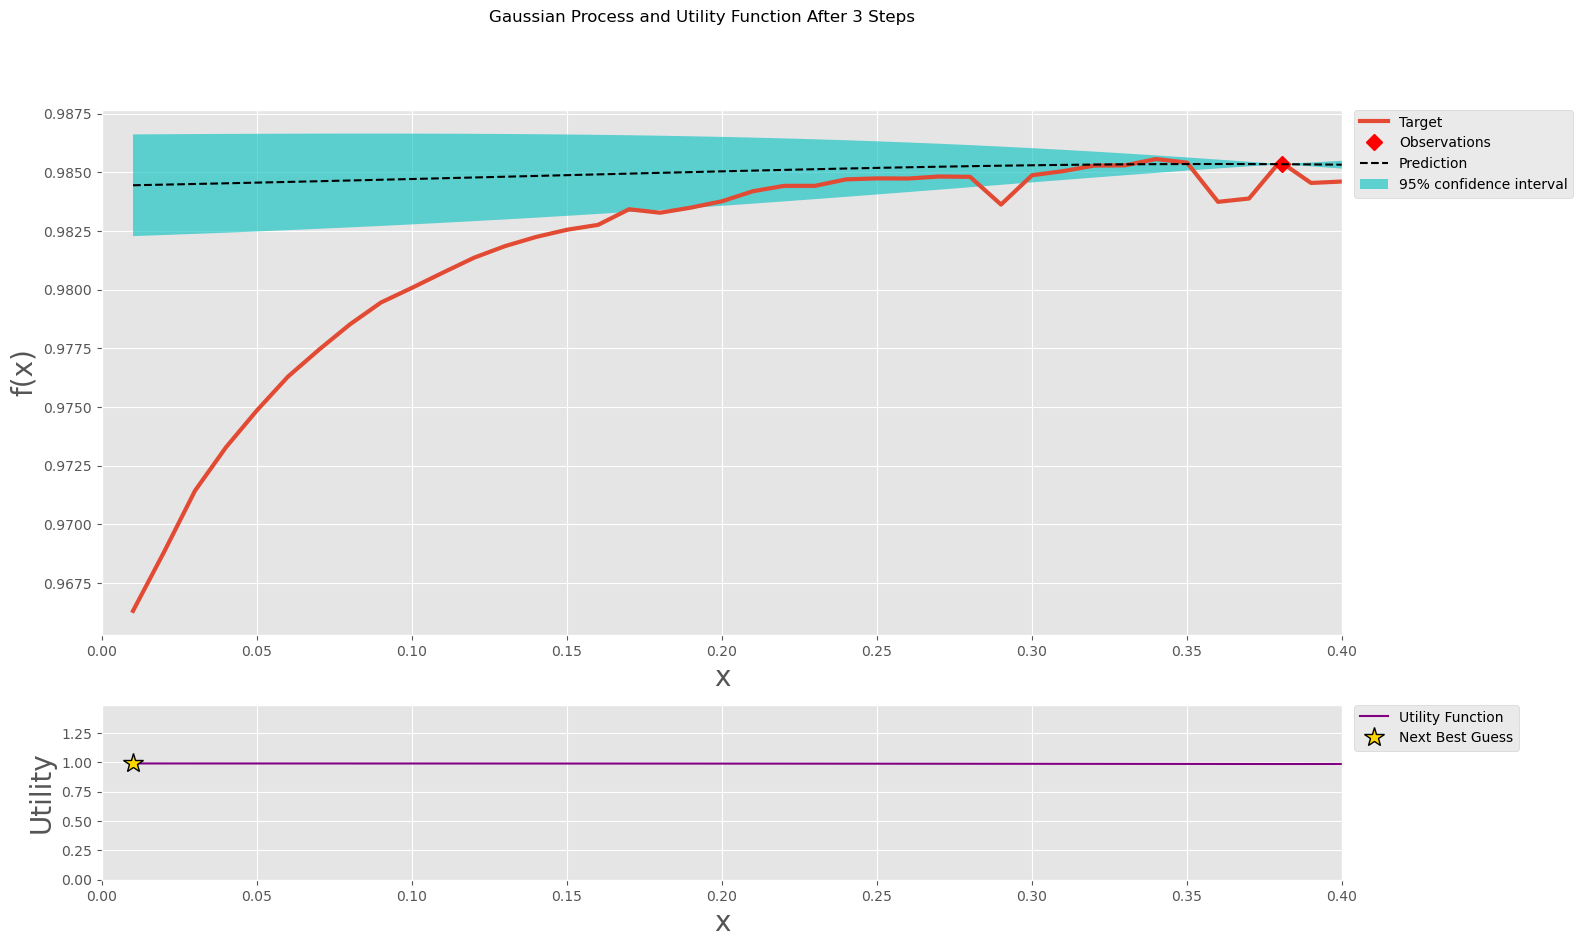

In [29]:
x1_gp = x_gp.reshape(-1, 1)
y1_gp = y_gp.array.reshape(-1, 1)

optimizer.maximize(n_iter = 0, init_points = 2, kappa = 5)
plot_gp(optimizer, x1_gp, y1_gp)

|   iter    |  target   | learni... |
-------------------------------------


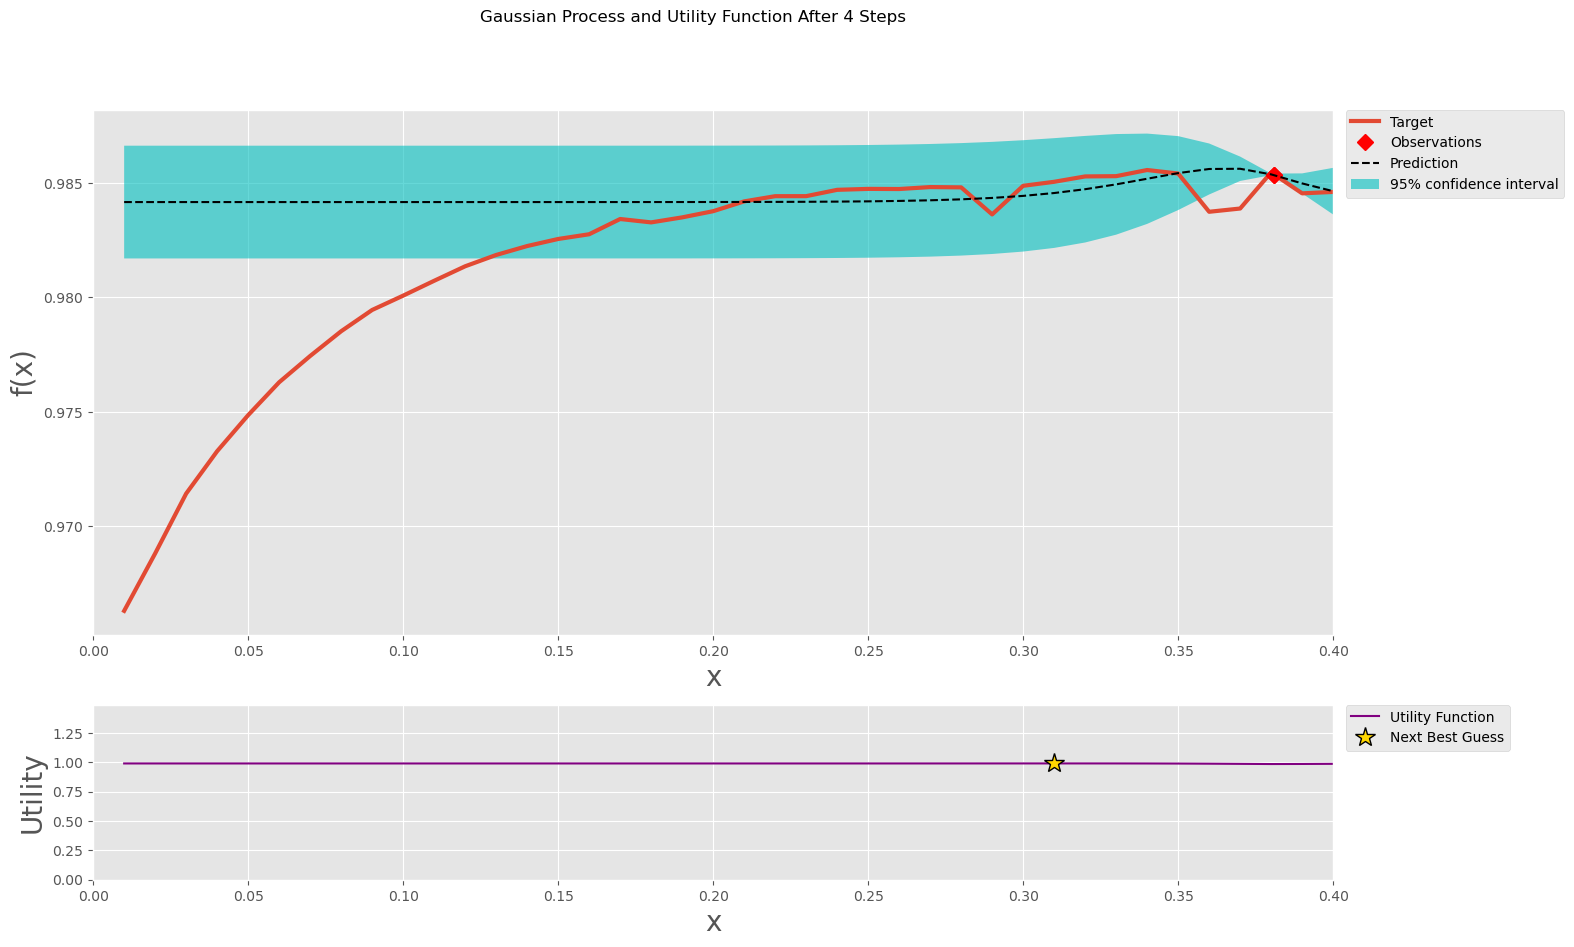

In [30]:
optimizer.maximize(init_points = 0, 
                   n_iter = 1, 
                   kappa = 5)

plot_gp(optimizer, x1_gp, y1_gp)

|   iter    |  target   | learni... |
-------------------------------------
| 5         | 0.9855    | 0.3308    |


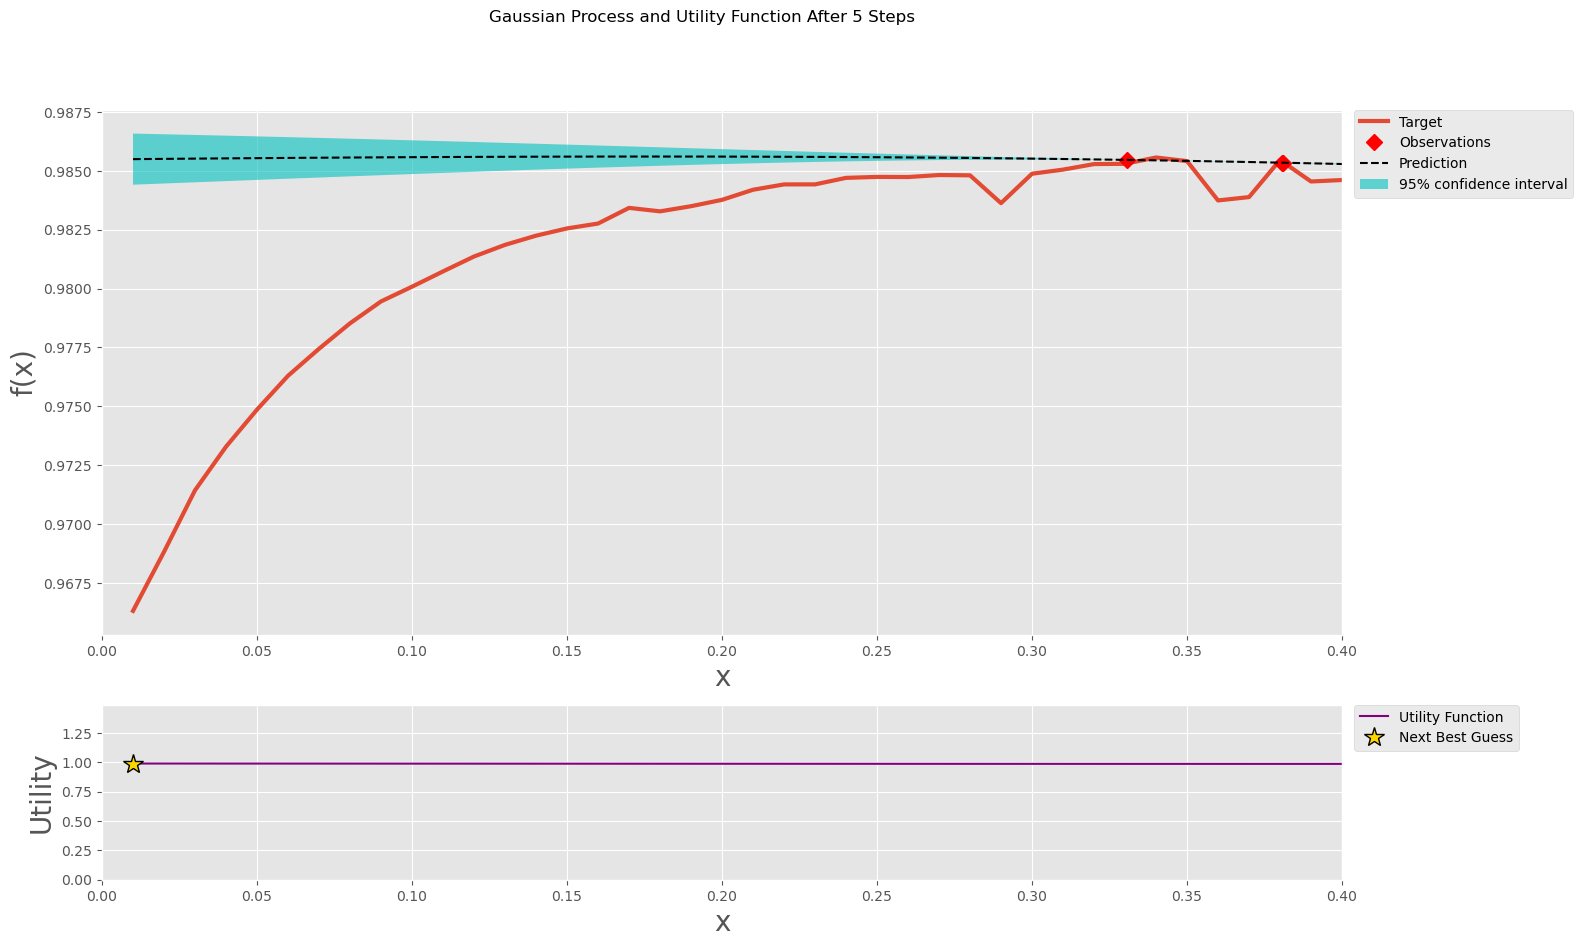

In [31]:
optimizer.maximize(init_points = 0, 
                   n_iter = 1, 
                   kappa = 5)

plot_gp(optimizer, x1_gp, y1_gp)

|   iter    |  target   | learni... |
-------------------------------------


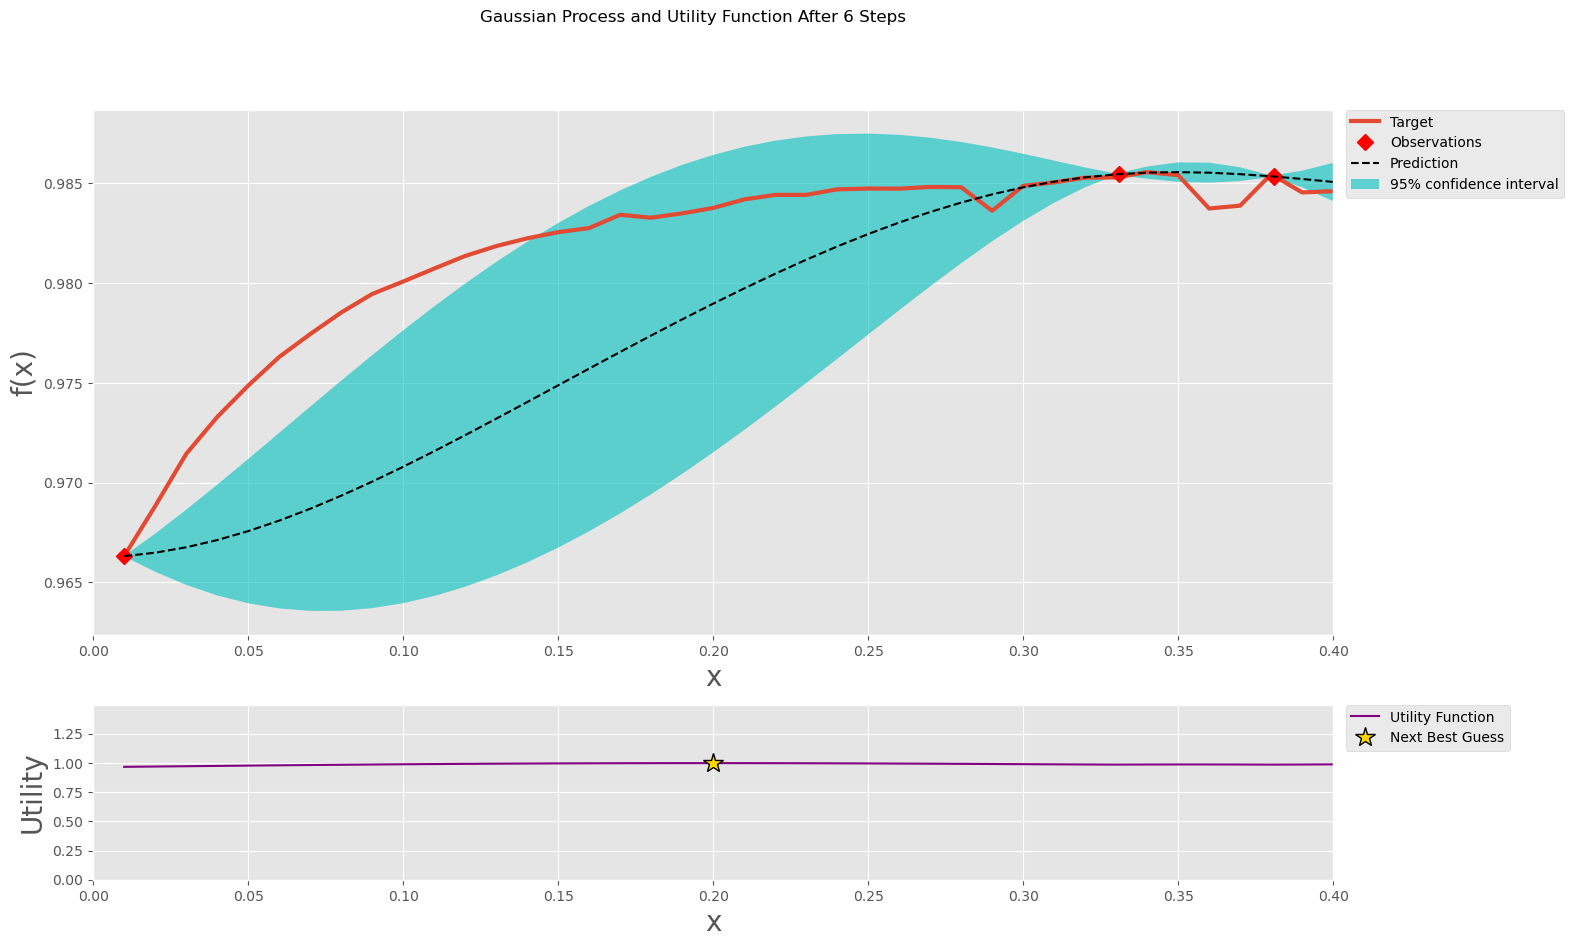

In [32]:
optimizer.maximize(init_points = 0, 
                   n_iter = 1, 
                   kappa = 5)

plot_gp(optimizer, x1_gp, y1_gp)

|   iter    |  target   | learni... |
-------------------------------------


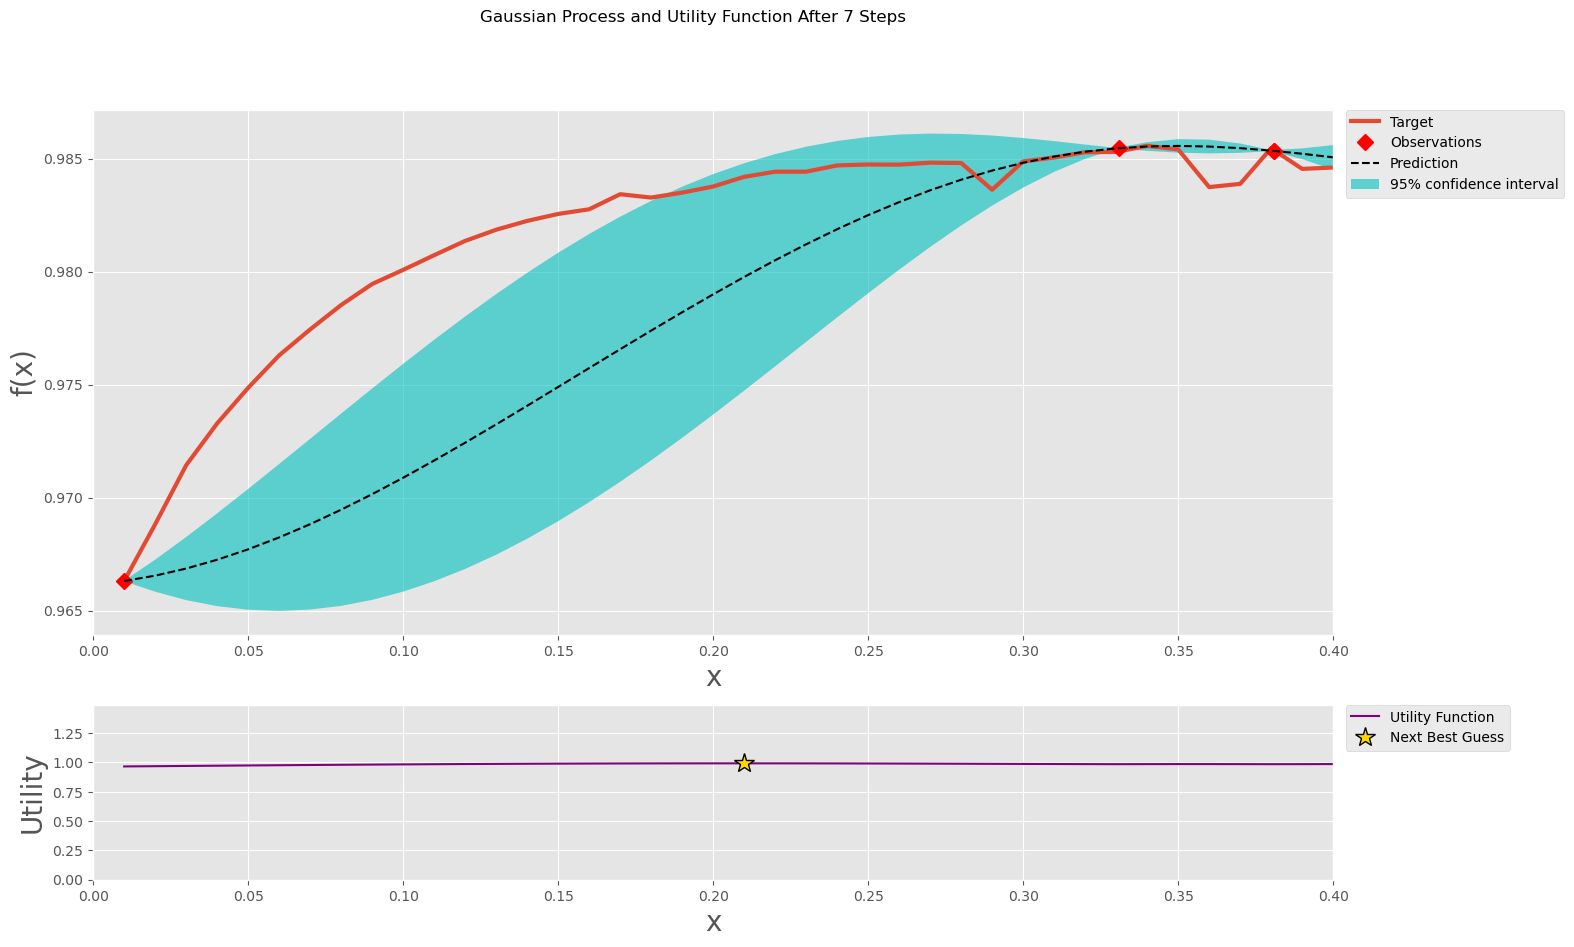

In [33]:
optimizer.maximize(init_points = 0, 
                   n_iter = 1, 
                   kappa = 5)

plot_gp(optimizer, x1_gp, y1_gp)

|   iter    |  target   | learni... |
-------------------------------------


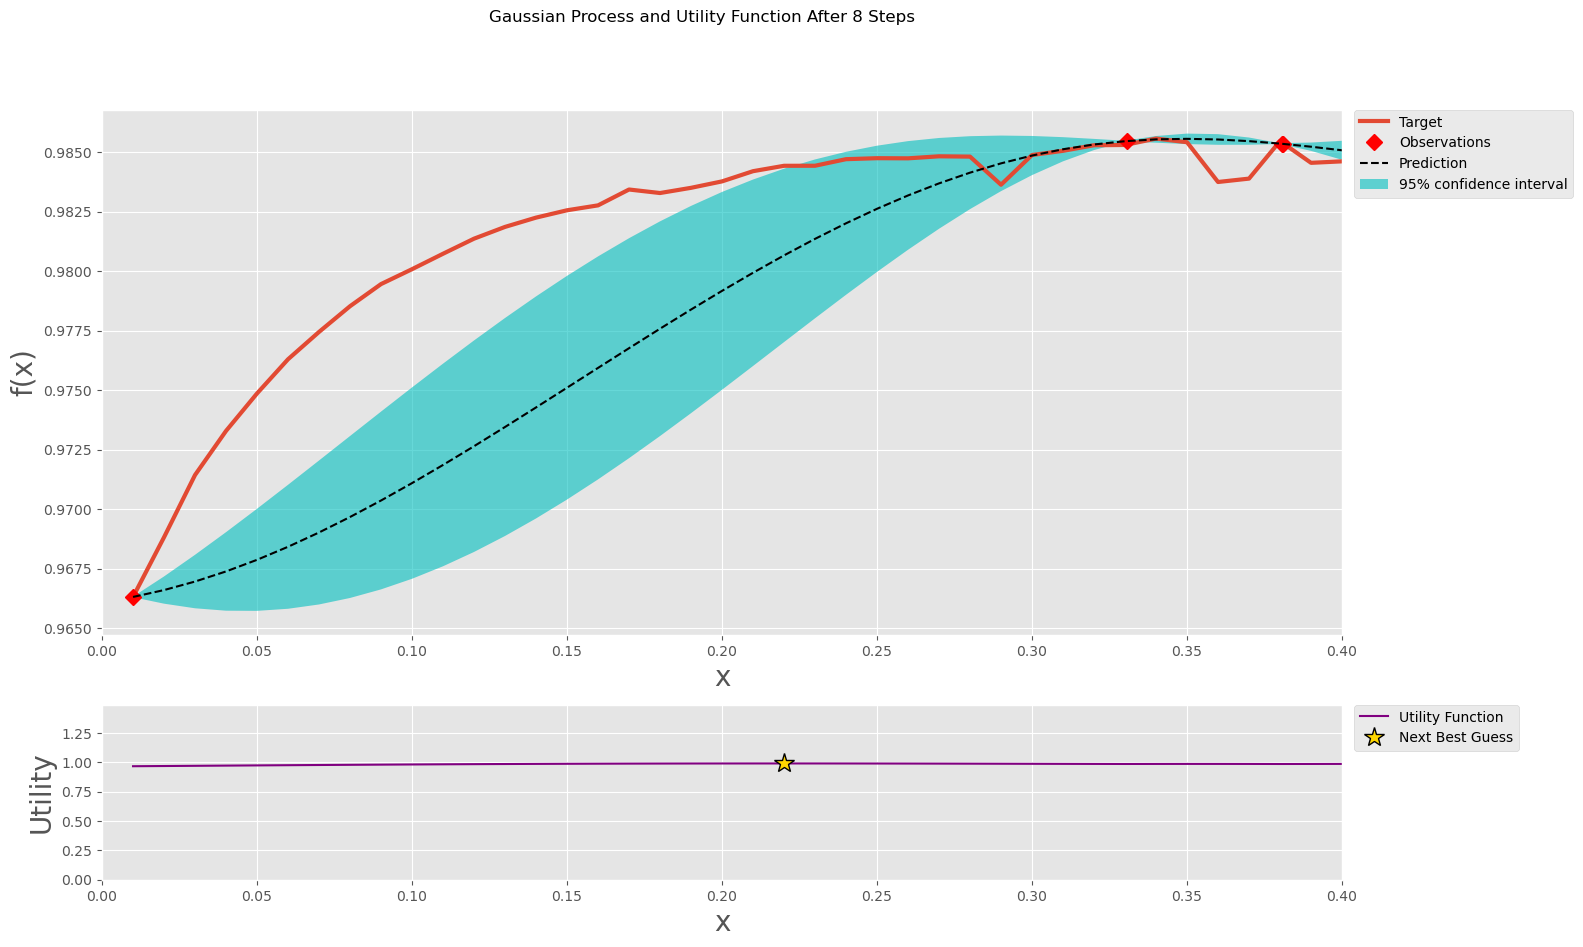

In [34]:
optimizer.maximize(init_points = 0, 
                   n_iter = 1, 
                   kappa = 5)

plot_gp(optimizer, x1_gp, y1_gp)

|   iter    |  target   | learni... |
-------------------------------------


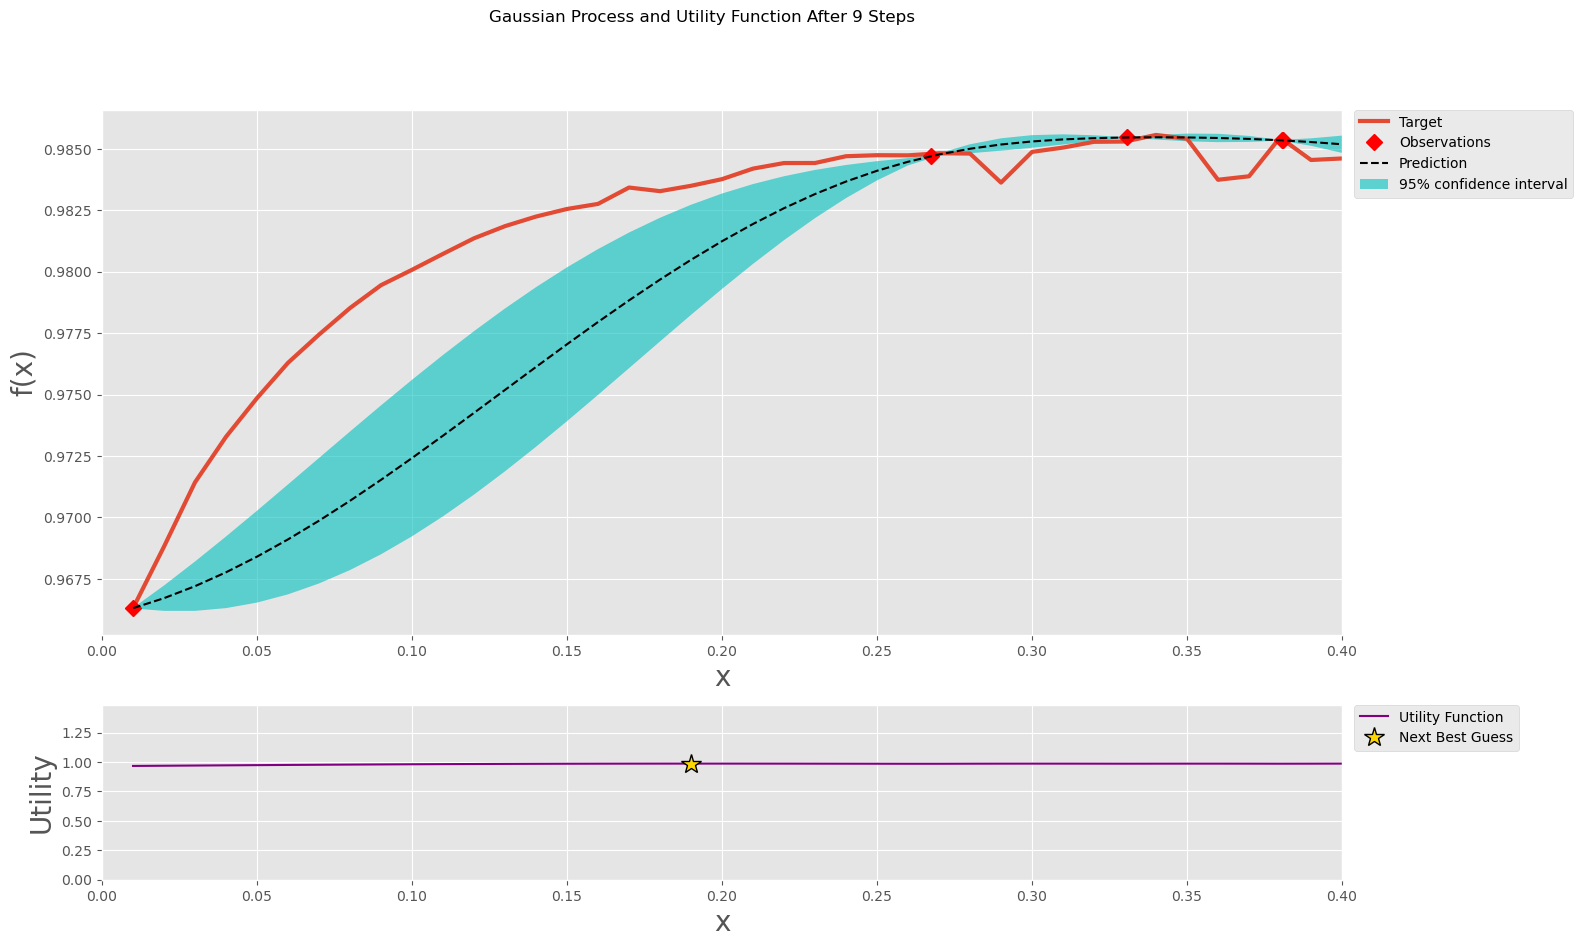

In [35]:
optimizer.maximize(init_points = 0, 
                   n_iter = 1, 
                   kappa = 5)

plot_gp(optimizer, x1_gp, y1_gp)